# Ex10. 프로젝트 : 단어 Level로 번역기 업그레이드하기

## 0. 환경설정 및 라이브러리 import

In [1]:
# ! mkdir -p ~/aiffel/translator_seq2seq/data
# ! mkdir -p ~/aiffel/translator_seq2seq/models
# ! wget https://www.manythings.org/anki/fra-eng.zip
# ! mv fra-eng.zip  ~/aiffel/translator_seq2seq/data
# ! cd ~/aiffel/translator_seq2seq/data && unzip fra-eng.zip

In [2]:
import os
import re
import unicodedata

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

## 1. 정제, 정규화, 전처리 (영어, 프랑스어 모두!)

### 1-1. 전처리 함수 구현

In [3]:
def to_ascii(s):
    # 프랑스어 악센트(accent) 삭제
    # 예시 : 'déjà diné' -> deja dine
    return ''.join(c for c in unicodedata.normalize('NFD', s)
                   if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sent):
    # 악센트 제거 함수 호출
    sent = to_ascii(sent.lower())

    # 단어와 구두점 사이에 공백 추가.
    # ex) "I am a student." => "I am a student ."
    sent = re.sub(r"([?!,.])", r" \1", sent)

    # (a-z, A-Z, "?", "!", ",", ".", "'") 이들을 제외하고는 전부 공백으로 변환.
    sent = re.sub(r"[^a-zA-Z?!,.']+", r" ", sent)

    # 다수 개의 공백을 하나의 공백으로 치환
    sent = re.sub(r"\s+", " ", sent)

    return sent

### 1-2. 데이타 로딩,불필요한 프랑스어 액센트 삭제, 불필요한 구두점 제거 및 시작토큰/종료토큰 추가

In [4]:
def load_preprocessed_data(num_samples):
    encoder_input, decoder_input, decoder_target = [], [], []

    with open("fra.txt", "r") as lines:
        for i, line in enumerate(lines):
            # source 데이터와 target 데이터 분리
            src_line, tar_line, _ = line.strip().split('\t')

            # source 데이터 전처리
            src_line = [w for w in preprocess_sentence(src_line).split()]

            # target 데이터 전처리
            tar_line = preprocess_sentence(tar_line)
            tar_line_in = [w for w in ("<sos> " + tar_line).split()]
            tar_line_out = [w for w in (tar_line + " <eos>").split()]

            encoder_input.append(src_line)
            decoder_input.append(tar_line_in)
            decoder_target.append(tar_line_out)

            if i == num_samples - 1:
                break

    return encoder_input, decoder_input, decoder_target

In [5]:
num_samples = 33000

sents_en_in, sents_fra_in, sents_fra_out = load_preprocessed_data(num_samples)
print('인코더의 입력 :',sents_en_in[:10])
print('디코더의 입력 :',sents_fra_in[:10])
print('디코더의 레이블 :',sents_fra_out[:10])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.'], ['run', '!'], ['run', '!'], ['run', '!'], ['run', '!']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'en', 'route', '!'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.'], ['<sos>', 'cours', '!'], ['<sos>', 'courez', '!'], ['<sos>', 'prenez', 'vos', 'jambes', 'a', 'vos', 'cous', '!'], ['<sos>', 'file', '!']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['en', 'route', '!', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>'], ['cours', '!', '<eos>'], ['courez', '!', '<eos>'], ['prenez', 'vos', 'jambes', 'a', 'vos', 'cous', '!', '<eos>'], ['file', '!', '<eos>']]


#### 데이터에대한 전처리가 잘 수행되었다.

## 2. 띄어쓰기 단위로 토크나이징, 정수 인코딩 및 패딩 진행

In [6]:
tokenizer_en = Tokenizer(filters="", lower=False)
tokenizer_en.fit_on_texts(sents_en_in)                        # 띄어쓰기 단위로 토크나이징
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)  # 정수 인코딩
encoder_input = pad_sequences(encoder_input, padding="post")  # 패딩 진행  

tokenizer_fra = Tokenizer(filters="", lower=False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_input = pad_sequences(decoder_input, padding="post")

decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)
decoder_target = pad_sequences(decoder_target, padding="post")

print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

print()
print(encoder_input[1000:1010])
print()
print(decoder_input[1000:1010])
print()
print(decoder_target[1000:1010])

인코더의 입력의 크기(shape) : (33000, 7)
디코더의 입력의 크기(shape) : (33000, 15)
디코더의 레이블의 크기(shape) : (33000, 15)

[[ 38   2  85   1   0   0   0]
 [420   1   0   0   0   0   0]
 [316 680   1   0   0   0   0]
 [316 680   1   0   0   0   0]
 [316  14   1   0   0   0   0]
 [316  14   1   0   0   0   0]
 [316  14   1   0   0   0   0]
 [316  14   1   0   0   0   0]
 [316  14   1   0   0   0   0]
 [ 48 488  20   0   0   0   0]]

[[   2   25  220    1    0    0    0    0    0    0    0    0    0    0
     0]
 [   2  399 1230 5114    1    0    0    0    0    0    0    0    0    0
     0]
 [   2 5115   82  485    7    0    0    0    0    0    0    0    0    0
     0]
 [   2  805   13  485    7    0    0    0    0    0    0    0    0    0
     0]
 [   2  528    1    0    0    0    0    0    0    0    0    0    0    0
     0]
 [   2  470   26    7    0    0    0    0    0    0    0    0    0    0
     0]
 [   2  528   26    7    0    0    0    0    0    0    0    0    0    0
     0]
 [   2  528   99    7    0  

#### 토크나이징, 정수 인코딩 및 패딩까지 잘 진행되었다.

## 3. 영어, 프랑스어 단어장 만들기

In [7]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1
print("영어 단어 집합의 크기 : {:d}, 프랑스어 단어 집합의 크기 : {:d}".format(src_vocab_size, tar_vocab_size))

영어 단어 집합의 크기 : 4769, 프랑스어 단어 집합의 크기 : 8728


In [8]:
# 단어장을 만듦, 예측값과 실제값을 비교하는데 사용
src_to_index = tokenizer_en.word_index
index_to_src = tokenizer_en.index_word
tar_to_index = tokenizer_fra.word_index
index_to_tar = tokenizer_fra.index_word

### 3-5. 전체 데이타 33000개 중 3000개를 validation용으로 분리

In [9]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [21858 12609 12035 ... 21096 15230  6793]


In [10]:
# 데이터셋의 순서로 지정 (기존과 다른 순서로 섞임)
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [11]:
n_of_val = 3000

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (30000, 7)
훈련 target 데이터의 크기 : (30000, 15)
훈련 target 레이블의 크기 : (30000, 15)
테스트 source 데이터의 크기 : (3000, 7)
테스트 target 데이터의 크기 : (3000, 15)
테스트 target 레이블의 크기 : (3000, 15)


## 4. 임베딩 층(Embedding layer) 사용하기

### 4-1. 모델 작성하기

In [12]:
embedding_dim = 128
hidden_units = 128

In [13]:
# 인코더
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs) # 임베딩 층
enc_masking = Masking(mask_value=0.0)(enc_emb) # 패딩 0은 연산에서 제외
encoder_lstm = LSTM(hidden_units, dropout = 0.4, recurrent_dropout=0.4, return_state=True) # 상태값 리턴을 위해 return_state는 True
encoder_outputs, state_h, state_c = encoder_lstm(enc_masking) # 은닉 상태와 셀 상태를 리턴
encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

In [14]:
# 디코더
decoder_inputs = Input(shape=(None,))
dec_emb_layer = Embedding(tar_vocab_size, hidden_units) # 임베딩 층
dec_emb = dec_emb_layer(decoder_inputs) # 패딩 0은 연산에서 제외
dec_masking = Masking(mask_value=0.0)(dec_emb)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, dropout = 0.4, recurrent_dropout=0.4, return_sequences=True, return_state=True) 

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_masking,
                                     initial_state=encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 128)    610432      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1117184     input_2[0][0]                    
______________________________________________________________________________________________

### 4-2. 모델 훈련하기

In [15]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
235/235 [==============================] - 31s 109ms/step - loss: 2.8095 - val_loss: 1.8529
Epoch 2/50
235/235 [==============================] - 25s 104ms/step - loss: 1.7452 - val_loss: 1.6542
Epoch 3/50
235/235 [==============================] - 24s 103ms/step - loss: 1.6047 - val_loss: 1.5640
Epoch 4/50
235/235 [==============================] - 24s 103ms/step - loss: 1.5135 - val_loss: 1.4733
Epoch 5/50
235/235 [==============================] - 24s 102ms/step - loss: 1.3994 - val_loss: 1.3539
Epoch 6/50
235/235 [==============================] - 24s 103ms/step - loss: 1.2786 - val_loss: 1.2581
Epoch 7/50
235/235 [==============================] - 24s 104ms/step - loss: 1.1865 - val_loss: 1.1899
Epoch 8/50
235/235 [==============================] - 25s 104ms/step - loss: 1.1143 - val_loss: 1.1398
Epoch 9/50
235/235 [==============================] - 25s 107ms/step - loss: 1.0540 - val_loss: 1.0976
Epoch 10/50
235/235 [==============================] - 24s 101ms/step - l

### 4-3. 모델 훈련결과 시각화

In [16]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'val_loss'])


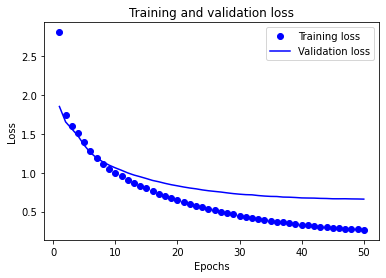

In [17]:
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

# bo는 파란색 점
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 파란색 실선
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

#### Validation loss가 epoch 10 (1.1755)까지 급격히 떨어진 이후 epoch 50 (0.7291)까지 완만히 떨어지고 있다.

## 5. 테스트 모델 구현하기

In [18]:
# 인코더
encoder_model = Model(encoder_inputs, encoder_states)
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding (Embedding)        (None, None, 128)         610432    
_________________________________________________________________
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 128), (None, 128) 131584    
Total params: 742,016
Trainable params: 742,016
Non-trainable params: 0
_________________________________________________________________


In [19]:
# 디코더 설계 시작
# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 128)    1117184     input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 128)]        0                                            
____________________________________________________________________________________________

In [20]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
    states_value = encoder_model.predict(input_seq)

    # SOS_token에 해당하는 정수 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_to_index['<sos>']

    stop_condition = False
    decoded_sentence = ''

    # stop_condition이 True가 될 때까지 루프 반복
    # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
    while not stop_condition:
        # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # 예측 결과를 단어로 변환
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = index_to_tar[sampled_token_index]

        # 현재 시점의 예측 단어를 예측 문장에 추가
        decoded_sentence += ' '+sampled_char

        # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
        if (sampled_char == '<eos>' or
            len(decoded_sentence) > 50):
            stop_condition = True

        # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
        states_value = [h, c]

    return decoded_sentence

In [21]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0):
            sentence = sentence + index_to_src[encoded_word] + ' '
    return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
    sentence = ''
    for encoded_word in input_seq:
        if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
            sentence = sentence + index_to_tar[encoded_word] + ' '
    return sentence

In [22]:
# 테스트 해보기
for seq_index in [500,1000,1500,2000,2500]:
    input_seq = encoder_input_test[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    
    print(35 * "-")
    print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
    print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
    print("번역문장 :",decoded_sentence[1:-5])

-----------------------------------
입력문장 : everyone can play . 
정답문장 : tout le monde peut y jouer . 
번역문장 : tout le monde le francais . 
-----------------------------------
입력문장 : come over . 
정답문장 : venez chez moi ! 
번역문장 : venez ici . 
-----------------------------------
입력문장 : forget what i said . 
정답문장 : oubliez ce que j'ai dit ! 
번역문장 : oublie ce que j'ai dit . 
-----------------------------------
입력문장 : wash everything . 
정답문장 : lave tout . 
번역문장 : nettoie tout . 
-----------------------------------
입력문장 : tom has red hair . 
정답문장 : tom a les cheveux roux . 
번역문장 : tom a les cheveux rouges . 


## 한글로 번역 (구글번역)하여 비교

-----------------------------------
입력문장 : everyone can play . (모두가 재생할 수 있습니다)

정답문장 : tout le monde peut y jouer . (누구나 재생할 수 있습니다)

번역문장 : tout le monde le francais . (모두 프랑스)

-----------------------------------
입력문장 : come over . (이리와)

정답문장 : venez chez moi ! (집으로와)

번역문장 : venez ici . (여기와)

-----------------------------------
입력문장 : forget what i said . (내가 말한 건 잊어)

정답문장 : oubliez ce que j'ai dit ! (내가 말한 건 잊어)

번역문장 : oublie ce que j'ai dit . (내가 말한 건 잊어)

-----------------------------------
입력문장 : wash everything . (모든 것을 씻다)

정답문장 : lave tout . (모든 것을 씻다)

번역문장 : nettoie tout . (모든 것을 청소)

-----------------------------------
입력문장 : tom has red hair . (톰은 빨간 머리를 하고 있다)

정답문장 : tom a les cheveux roux . (톰은 빨간 머리를 하고 있다)

번역문장 : tom a les cheveux rouges . (톰은 빨간 머리를 하고 있다)

#### 번역기가 기능적으로 잘 작동하고 있고 30,000개의 데이타로 20여분 훈련한 성과치곤 우수한 편이다.

## 회고
### 이번 프로젝트에서 어려웠던 점

model.fit 과정에서 "valueerror: shapes (none, 14) and (none, 14, 11164) are incompatible"가 발생 하였는데 해결하느라 무척 애를 먹었다. 구글링, 유튜브 검색을 아무리 해봐도 해결하지 못하다가 우연히 구글링에서 답을 찾았다. model.compile시 loss function을 one-hot-encoding시 적용하는 "categorical_crossentropy"에서 label값이 정수인 경우 사용하는 "sparse_categorical_crossentropy"로 바꾸어주니 해결되었다. 

### 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

앞부분 sample이 상대적으로 짧은문장으로 되어있어 중간부분에서 선택해 보았는데 전처리 과정 중 대문자를 소문자로 바꾸어주는 line.lower() 기능이 작동되지 않았다. 아무리 생각해 봐도 이유를 모르겠다.

### 루브릭 평가 지표를 맞추기 위해 시도한 것들

1. Validation loss가 지속적으로 우하향하지 않아 overfitting이 발생한다고 보아 dropout 및 recurrent_dropout을 적용하였다. 다소 개선되었으나 training loss가 꾸준히 줄어드는 많큼 줄어들지 않는다.
2. optimizer를 rmsprop에서 보편적으로 많이 사용하는 adam으로 바꾸었다.
3. embedding_dim, hidden_units 및 batch_size 등을 바꾸어 보았다.

### 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

번역성능 개선을 위하여 Sample 양을 늘리고 싶었으나 33,000개를 사용하라는 조건이 있어 시도하지 않았다.

### 자기 다짐

아직 모델작성 및 성능개선 방법이 미숙하다. 첫술에 배부르랴. 앞으로의 과정도 열심히 하자.